# Connect to drive & import libraries

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import os
from keras.engine import Layer
from keras.layers import Lambda, Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import numpy as np
import nltk
import tqdm
import tensorflow_hub as hub
import string
from keras import backend as K
import tensorflow as tf
import tensorflow.keras.backend as B
import tensorflow_hub as hub
import re
from tensorflow.python.keras.engine import Layer

Using TensorFlow backend.


In [0]:
tf.__version__

'1.15.2'

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Constants

In [0]:
# data parameters
dataset_address = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
test_data_percentage = 0.2
# model parameters
learning_rate = 0.0002
batch_size = 32
max_sequence_length = 128
number_of_epochs = [1, 10, 20, 50]
# model links
bert_model_hub_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
elmo_model_hub_link = 'https://tfhub.dev/google/elmo/3'

# Reading & Pre-processing the data

In [0]:
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin=dataset_address, 
        extract=True)
  
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                         "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                          "aclImdb", "test"))
    return train_df, test_df
 
train, test = download_and_load_datasets()

84131840/84125825 [==============================] - 2s 0us/step


In [0]:
train.head(7)

,sentence,sentiment,polarity
0,Slaughter High is about a boy named Marty. He ...,8,1
1,Poor Whoopi Goldberg. Imagine her at a friend'...,1,0
2,"Joan Crawford had just begun her ""working girl...",8,1
3,"a timeless classic, wonderfully acted with per...",10,1
4,"I admit to liking a lot of the so-called ""frat...",2,0
5,"A most recommendable masterpiece, not only for...",10,1
6,I really enjoyed this thriller! I wanted to se...,10,1


In [0]:
train_X = train.sentence.values
train_Y = train.polarity.values

test_X = test.sentence.values
test_Y = test.polarity.values
print(len(train_X), len(test_X))

25000 25000


## Clean and tokenize 

In [0]:
def clean_text(all_X, tokenizer_mod=None):
  nltk_eng_stopwords = nltk.corpus.stopwords.words('english')
  converted_X = []
  for this_x in all_X:
    this_x_lower = this_x.lower()
    this_x_no_punc = this_x_lower.translate(str.maketrans('', '', string.punctuation))
    if tokenizer_mod == None:
      this_x_tokenized = nltk.tokenize.word_tokenize(this_x_no_punc)
      this_x_no_stopword = [val for val in this_x_tokenized if not val in nltk_eng_stopwords]
      converted_X.append(this_x_no_stopword)
    else:
      this_x_no_stopword = " ".join([val for val in nltk.tokenize.word_tokenize(this_x_no_punc) if not val in nltk_eng_stopwords])
      this_x_tokenized = tokenizer_mod.tokenize(this_x_no_stopword)
      converted_X.append(this_x_tokenized)
  return converted_X

def convert_y_to_0_and_1(all_Y):
  label_number_mapping = {0: [1, 0], 1: [0, 1]}
  converted_y = [label_number_mapping[val] for val in all_Y]
  return converted_y

In [0]:
all_train_X_cleaned = clean_text(train_X)

In [0]:
all_test_X_cleaned = clean_text(test_X)

In [0]:
all_train_y_converted = convert_y_to_0_and_1(train_Y)
all_test_y_converted = convert_y_to_0_and_1(test_Y)

### Testing Elmo results

In [0]:
print('X[0] => before: {} and after: {}'.format(train_X[0], all_train_X_cleaned[0]))
print('Y[0] => before: {} and after: {}'.format(train_Y[0], all_train_y_converted[0]))

X[0] => before: Slaughter High is about a boy named Marty. He was harassed, and picked on in high school. A group of kids played several pranks on him, and these pranks were REALLY bad. The last prank ended tragically.<br /><br />cue to 5 years later. The gang of kids meet up again for a reunion. One of them set it up at the old high school. The school is now abandoned, and they have to break in. For some reason, the Janitor is still there, but he tells them to go ahead and have fun because they give him a beer.<br /><br />They start partying ,and looking at their old lockers, and they see something of Marty's. One girl feels sorry for Marty but another guy calms her down.<br /><br />Once the kills begin, it is great. Every kills is creative and gory. We see a figure in a jester mask, hunting them one by one throughout the school. It appears Marty is back to exact revenge. After the first person is killed, they find out they are locked in the school. They begin looking for a way out.<b

# Creating Model

## Using Elmo

In [0]:
all_X_preped_for_elmo_train = []
for val in all_train_X_cleaned:
  val_splitted = val[:max_sequence_length]
  val_to_add = ' '.join(val_splitted)
  all_X_preped_for_elmo_train.append(val_to_add)

In [0]:
all_X_preped_for_elmo_test = []
for val in all_test_X_cleaned:
  val_splitted = val[:max_sequence_length]
  val_to_add = ' '.join(val_splitted)
  all_X_preped_for_elmo_test.append(val_to_add)

In [0]:
X_train_elmo = np.asarray(all_X_preped_for_elmo_train, dtype="str")
X_test_elmo = np.asarray(all_X_preped_for_elmo_test, dtype="str")
y_train_elmo = np.asarray(all_train_y_converted, dtype=np.int32)

In [0]:
elmo = hub.Module(elmo_model_hub_link, trainable = True)
def get_elmo_embedding_for_each_input_using_lambda_function(inp):
  return elmo(tf.squeeze(tf.cast(inp, tf.string)), signature='default', as_dict=True)['default']

In [0]:
def create_elmo_using_model():
  input_text = Input(shape=(1,), dtype="string")
  embeddings = Lambda(get_elmo_embedding_for_each_input_using_lambda_function, output_shape=(1024, ))(input_text)
  dense = Dense(1024, activation='relu')(embeddings)
  pred = Dense(2, activation='softmax')(dense)
  model = Model(inputs=[input_text], outputs=pred)
  return model 

In [0]:
def evaluate_model_elmo(model):
  # elmo_test_input = [np.array(X_test_elmo_tokens), np.array(X_test_elmo_seqlens)]
  predicted_y = model.predict(X_test_elmo)
  y_test_conv = [np.argmax(val) for val in all_test_y_converted]
  predicted_y_conv = [np.argmax(val) for val in predicted_y]
  print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
  print('Classification report:', classification_report(y_test_conv, predicted_y_conv))
  print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
  print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
  print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
  fpr, tpr, thresholds = metrics.roc_curve(y_test_conv, predicted_y_conv, pos_label=1)
  print('AUC:', metrics.auc(fpr, tpr))

In [0]:
def plot_accuracy_and_loss(file_save_name, history):
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_accuracy.png')
  plt.cla()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_loss.png')
  plt.cla()

In [0]:
this_optimizer = keras.optimizers.Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Number of epochs: 10
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 [==============================] - 336s 13ms/step - loss: 0.4550 - accuracy: 0.7833
Epoch 2/10
25000/25000 [==============================] - 329s 13ms/step - loss: 0.4088 - accuracy: 0.8145
Epoch 3/10
25000/25000 [==============================] - 329s 13ms/step - loss: 0.3881 - accuracy: 0.8262
Epoch 4/10
25000/25000 [==============================] - 328s 13ms/step - loss: 0.3788 - accuracy: 0.8282
Epoch 5/10
25000/25000 [==============================] - 328s 13ms/step - loss: 0.3698 - accuracy: 0.8362
Epoch 6/10
25000/25000 [==============================] - 327s 13ms/step - loss: 0.3643 - accuracy: 0.8368
Epoch 7/10
25000/25000 [==============================] - 328s 13ms/step - loss: 0.3511 - accuracy: 0.8466
Epoch 8/10
25000/25000 [==============================] - 328s 13ms/step - loss: 0.3457 - accuracy: 0.8462
Epoch 9/10
25000/25000 [==============================] - 328s 13ms/step - loss: 0.3332 - accuracy: 0.8543
Epoch 10/10
25000/25000 [============

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
25000/25000 [==============================] - 331s 13ms/step - loss: 0.4517 - accuracy: 0.7894
Epoch 2/20
25000/25000 [==============================] - 330s 13ms/step - loss: 0.4018 - accuracy: 0.8165
Epoch 3/20
25000/25000 [====

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
25000/25000 [==============================] - 329s 13ms/step - loss: 0.4619 - accuracy: 0.7826
Epoch 2/50
25000/25000 [==============================] - 329s 13ms/step - loss: 0.4030 - accuracy: 0.8174
Epoch 3/50
25000/25000 [====

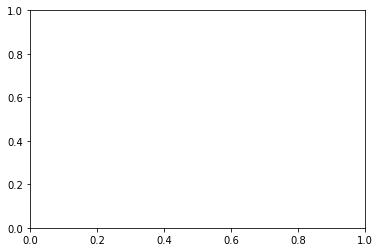

In [0]:
for epochs in number_of_epochs[1:]:
  print('Number of epochs:', epochs)
  model = create_elmo_using_model()
  print(model.summary())
  model.compile(loss='binary_crossentropy', optimizer=this_optimizer, metrics=['accuracy'])
  history = model.fit(
      X_train_elmo, 
      y_train_elmo,
      epochs=epochs,
      batch_size=batch_size
  )
  print('Done training')
  image_save_file_name = 'drive/My Drive/CA5_Sabri_810198312/Results/Q2_elmo_model_{}_epochs'.format(epochs)
  plot_accuracy_and_loss(image_save_file_name, history)
  evaluate_model_elmo(model)

In [0]:
history.history

{'accuracy': [0.78264,
  0.81744,
  0.82404,
  0.82952,
  0.83532,
  0.83636,
  0.84124,
  0.84284,
  0.84328,
  0.85144,
  0.85204,
  0.85688,
  0.85992,
  0.8654,
  0.86612,
  0.86988,
  0.87568,
  0.8752,
  0.87992,
  0.88428,
  0.88736,
  0.89276,
  0.8938,
  0.89888,
  0.9014,
  0.90664,
  0.9112,
  0.91316,
  0.91832,
  0.91976,
  0.9246,
  0.92864,
  0.93316,
  0.93704,
  0.9388,
  0.94176,
  0.94616,
  0.94944,
  0.9548,
  0.95608,
  0.9562,
  0.9622,
  0.96256,
  0.96532,
  0.96984,
  0.97412,
  0.97392,
  0.97528,
  0.97808,
  0.98088],
 'loss': [0.46185063940048215,
  0.4029558487224579,
  0.38897464941978455,
  0.37973092075347903,
  0.36989936302661897,
  0.36597238519191744,
  0.3581571912574768,
  0.35363118392944337,
  0.3487360620975494,
  0.3388598433494568,
  0.3366235333275795,
  0.3285354618263245,
  0.3214976783657074,
  0.3145997780704498,
  0.3095957474780083,
  0.3022749171257019,
  0.296624139509201,
  0.28967799945831296,
  0.28327900399327277,
  0.2761333114